In [152]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import re
# Carregar os dados
data = pd.read_excel(r'DADOS BRUTOS\ECQ_OUT_24.xlsx')
data = data[['ANF','MUNICIPIO','ENDERECO_ID','TESTES_ECQ','ECQ']]
data['TESTES_ECQ_OK'] = (data['TESTES_ECQ'] * data['ECQ']).round(0)
data = data.drop(columns=['ECQ'])
data = data[data['ANF'] == 83]
# Agrupar por ANF e Município (DEFINA AQUI)
grouped = data.groupby(['ANF', 'MUNICIPIO'])


C:\Users\F8058552\AppData\Roaming\Python\Python310\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [153]:
data

,ANF,MUNICIPIO,ENDERECO_ID,TESTES_ECQ,TESTES_ECQ_OK
2287,83.0,ARACAGI,PBAAG_0001,13.0,9.0
2288,83.0,ARARUNA,PBAAN_0001,57.0,27.0
2289,83.0,AGUA BRANCA,PBABW_0001,28.0,12.0
2290,83.0,AREIAL,PBAEA_0001,12.0,10.0
2291,83.0,AREIA,PBAEI_0001,150.0,80.0
...,...,...,...,...,...
2688,83.0,UIRAUNA,PBUIN_0001,82.0,37.0
2689,83.0,UMBUZEIRO,PBUUZ_0001,2.0,0.0
2690,83.0,VIEIROPOLIS,PBVIEI0001,9.0,0.0
2691,83.0,VARZEA,PBVRA_0001,15.0,0.0


In [154]:
trace = az.from_netcdf(r"modelos\trace_ECQ_normal_pyMC_OUT24.nc")

In [155]:
#print("Filtered data shape:", data.shape)
print("Group keys:", grouped.groups.keys())
#print("Trace variables:", list(trace.posterior.data_vars))

Group keys: dict_keys([(83.0, 'AGUA BRANCA'), (83.0, 'AGUIAR'), (83.0, 'ALAGOA GRANDE'), (83.0, 'ALAGOA NOVA'), (83.0, 'ALAGOINHA'), (83.0, 'ALHANDRA'), (83.0, 'AMPARO'), (83.0, 'APARECIDA'), (83.0, 'ARACAGI'), (83.0, 'ARARA'), (83.0, 'ARARUNA'), (83.0, 'AREIA'), (83.0, 'AREIA DE BARAUNAS'), (83.0, 'AREIAL'), (83.0, 'AROEIRAS'), (83.0, 'ASSUNCAO'), (83.0, 'BAIA DA TRAICAO'), (83.0, 'BANANEIRAS'), (83.0, 'BARAUNA'), (83.0, 'BARRA DE SANTA ROSA'), (83.0, 'BARRA DE SANTANA'), (83.0, 'BARRA DE SAO MIGUEL'), (83.0, 'BAYEUX'), (83.0, 'BELEM'), (83.0, 'BELEM DO BREJO DO CRUZ'), (83.0, 'BERNARDINO BATISTA'), (83.0, 'BOA VENTURA'), (83.0, 'BOA VISTA'), (83.0, 'BOM JESUS'), (83.0, 'BOM SUCESSO'), (83.0, 'BONITO DE SANTA FE'), (83.0, 'BOQUEIRAO'), (83.0, 'BORBOREMA'), (83.0, 'BREJO DO CRUZ'), (83.0, 'BREJO DOS SANTOS'), (83.0, 'CAAPORA'), (83.0, 'CABACEIRAS'), (83.0, 'CABEDELO'), (83.0, 'CACHOEIRA DOS INDIOS'), (83.0, 'CACIMBA DE AREIA'), (83.0, 'CACIMBA DE DENTRO'), (83.0, 'CACIMBAS'), (83.0, 'C

In [156]:
rows = []
for (anf, municipio), group in grouped:

    var_name = f"theta_site_{anf}_{municipio}"
    #print(var_name)
    if var_name in trace.posterior.data_vars:
        # Obter amostras do theta_site (dimensão: chain, draw, site_idx)
        theta_site_samples = trace.posterior[var_name]  # Formato (2, 2000, n_sites)
        
        # Extrair ENDERECO_IDs correspondentes aos índices dos sites
        endereco_ids = group['ENDERECO_ID'].tolist()
        
        # Iterar sobre cada site (ENDERECO_ID)
        for site_idx, endereco_id in enumerate(endereco_ids):
            # Extrair amostras para o site específico
            site_samples = theta_site_samples[:, :, site_idx].values.flatten()
            
            # Calcular estatísticas
            mean = site_samples.mean()
            std = site_samples.std()
            hdi_3, hdi_97 = az.hdi(site_samples, hdi_prob=0.94)
            
            rows.append({
                "ANF": anf,
                "MUNICIPIO": municipio,
                "ENDERECO_ID": endereco_id,
                "mean": round(mean, 2),
                "stddev": round(std , 2),
                "hdi_inf": round(hdi_3 , 2),
                "hdi_sup": round(hdi_97, 2)
            })


summary_df = pd.DataFrame(rows)

In [157]:
summary_df

,ANF,MUNICIPIO,ENDERECO_ID,mean,stddev,hdi_inf,hdi_sup
0,83.0,AGUA BRANCA,PBABW_0001,0.43,0.09,0.26,0.61
1,83.0,AGUIAR,PBAGY_0001,0.82,0.07,0.69,0.94
2,83.0,ALAGOA GRANDE,PBAGG_0001,0.86,0.08,0.72,0.99
3,83.0,ALAGOA NOVA,PBAGO_0001,0.42,0.13,0.20,0.67
4,83.0,ALAGOINHA,PBAHA_0001,0.07,0.07,0.00,0.19
...,...,...,...,...,...,...,...
401,83.0,UIRAUNA,PBUIN_0001,0.45,0.05,0.35,0.55
402,83.0,UMBUZEIRO,PBUUZ_0001,0.25,0.19,0.00,0.59
403,83.0,VARZEA,PBVRA_0001,0.05,0.06,0.00,0.15
404,83.0,VIEIROPOLIS,PBVIEI0001,0.08,0.08,0.00,0.24


1. impacto_acumulado (Impacto Acumulado)
O que é: Soma cumulativa da métrica de impacto (impacto) dos sites, ordenados do maior para o menor impacto (priorizando os piores sites).

Interpretação:
"Se corrigirmos os primeiros N sites desta lista, qual é o impacto total esperado na melhoria do ECQ do município?"

impacto_acumulado = sum(impacto_dos_sites_priorizados)

2. ganho_potencial_ecq (Ganho Potencial de ECQ)
O que é: Representa quanto o ECQ médio do município poderia aumentar se os sites prioritários fossem corrigidos, expresso como uma proporção do ECQ atual.

Interpretação:
"Se corrigirmos os primeiros N sites, qual é o aumento percentual esperado no ECQ médio do município?"

ganho_potencial_ecq = impacto_acumulado / mean_municipio

In [158]:
# 3. Extrair estatísticas dos sites
rows = []
for (anf, municipio), group in grouped:
    var_name = f"theta_site_{anf}_{municipio}"
    if var_name in trace.posterior.data_vars:
        theta_site_samples = trace.posterior[var_name]
        endereco_ids = group['ENDERECO_ID'].tolist()
        
        for site_idx, endereco_id in enumerate(endereco_ids):
            samples = theta_site_samples[..., site_idx].values.flatten()
            
            rows.append({
                "ANF": anf,
                "MUNICIPIO": municipio,
                "ENDERECO_ID": endereco_id,
                "mean_site": samples.mean(),
                "stddev_site": samples.std(),
                "hdi_inf": az.hdi(samples, hdi_prob=0.95)[0],
                "hdi_sup": az.hdi(samples, hdi_prob=0.95)[1]
            })

summary_df = pd.DataFrame(rows)

# 4. Extrair ECQ dos municípios (mu_municipio)
municipio_rows = []
for (anf, municipio) in grouped.groups.keys():
    var_name = f"mu_municipio_{anf}_{municipio}"
    if var_name in trace.posterior.data_vars:
        samples = trace.posterior[var_name].values.flatten()
        municipio_rows.append({
            "ANF": anf,
            "MUNICIPIO": municipio,
            "mean_municipio": samples.mean(),
            "stddev_municipio": samples.std(),
            "hdi_inf_Mun": az.hdi(samples, hdi_prob=0.95)[0],
            "hdi_sup_Mun": az.hdi(samples, hdi_prob=0.95)[1]
        })

municipio_stats = pd.DataFrame(municipio_rows)

In [159]:
municipio_stats

,ANF,MUNICIPIO,mean_municipio,stddev_municipio,hdi_inf_Mun,hdi_sup_Mun
0,83.0,AGUA BRANCA,0.436805,0.140464,0.153564,0.685485
1,83.0,AGUIAR,0.754026,0.115487,0.538006,0.976161
2,83.0,ALAGOA GRANDE,0.799040,0.111935,0.591356,0.984082
3,83.0,ALAGOA NOVA,0.432492,0.155557,0.133053,0.738275
4,83.0,ALAGOINHA,0.130238,0.099064,0.000288,0.322853
...,...,...,...,...,...,...
198,83.0,UIRAUNA,0.463646,0.129571,0.206812,0.714660
199,83.0,UMBUZEIRO,0.291857,0.187454,0.004808,0.649253
200,83.0,VARZEA,0.111111,0.088370,0.001384,0.278088
201,83.0,VIEIROPOLIS,0.145386,0.113997,0.001151,0.369241


In [160]:
# ========================================================
# 5. Juntar todos os dados e calcular FALHAS_ECQ (CORRIGIDO)
# ========================================================
merged_df = pd.merge(
    summary_df,
    data[['ANF', 'MUNICIPIO', 'ENDERECO_ID', 'TESTES_ECQ', 'TESTES_ECQ_OK']],
    on=['ANF', 'MUNICIPIO', 'ENDERECO_ID'],
    how='inner'
)

# Adicionar mean_municipio do municipio_stats
merged_df = pd.merge(
    merged_df,
    municipio_stats[['ANF', 'MUNICIPIO', 'mean_municipio', 'hdi_inf_Mun', 'hdi_sup_Mun']],  # <--- Adicione esta linha
    on=['ANF', 'MUNICIPIO'],
    how='left'
)

# Calcular FALHAS_ECQ
merged_df['FALHAS_ECQ'] = merged_df['TESTES_ECQ'] - merged_df['TESTES_ECQ_OK']

# 6. Calcular métricas de impacto REVISADAS
# Normalizar falhas por município (0 a 1)
merged_df['FALHAS_ECQ_norm'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['FALHAS_ECQ'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)
)

# Nova métrica de impacto: potencial de ganho proporcional às falhas
merged_df['impacto'] = (
    (1 - merged_df['mean_site']) *  # Potencial máximo de melhoria (0 a 1)
    merged_df['FALHAS_ECQ_norm']    # Peso pelo volume de falhas normalizado
)


In [161]:

# 7. Calcular total de testes por município
merged_df['total_testes_municipio'] = merged_df.groupby(
    ['ANF', 'MUNICIPIO']
)['TESTES_ECQ'].transform('sum')

# 8. Ordenar e acumular impacto
merged_df['rank'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['impacto'].rank(
    ascending=False, method='first'
)

# merged_df['impacto_acumulado'] = merged_df.groupby(
#     ['ANF', 'MUNICIPIO']
# )['impacto'].transform(lambda x: x.sort_values(ascending=False).cumsum())
# Nova fórmula: Ganho potencial por site (não acumulado)
# merged_df['ganho_potencial_ecq'] = (
#     (1 - merged_df['mean_site']).clip(lower=0) *  # Evita valores negativos
#     merged_df['FALHAS_ECQ'] / 
#     merged_df['total_testes_municipio'] 
# ) * 100

# Impacto = falhas brutas
merged_df['incECQ'] = merged_df['FALHAS_ECQ'] / merged_df['total_testes_municipio']


merged_df['rank'] = merged_df.groupby(['ANF', 'MUNICIPIO'])['incECQ'].rank(
    ascending=False, method='first'
)

In [162]:

# ========================================================
# 9. Saída final
# ========================================================
# 10. Saída final

final_df = merged_df[[
    'ANF', 'MUNICIPIO', 'ENDERECO_ID', 
    'hdi_inf','mean_site', 'hdi_sup', 'hdi_inf_Mun', 'mean_municipio' ,'hdi_sup_Mun',
    'FALHAS_ECQ', 'TESTES_ECQ', 'TESTES_ECQ_OK','incECQ', 'rank', 'impacto' 
    # HDI intervals for sites
   # Test counts
]].sort_values(
    by=['ANF', 'MUNICIPIO', 'rank'],
    ascending=[True, True, True]
)

# # Rename HDI columns for clarity
# final_df = final_df.rename(columns={
#     'hdi_inf_x': 'hdi_inf',
#     'hdi_sup_x': 'hdi_sup'
# })


In [163]:

# Verificação final do ranking
test_group = final_df.groupby(['ANF', 'MUNICIPIO']).first()
assert (test_group['rank'] == 1).all(), "Problema no ranking!"
final_df['mes'] = 'out/24'
# ========================================================
# 10. Exportar resultados
# ========================================================
final_df.to_excel(r"_RESULTADO/priorizacao_sites_ECQ_out24.xlsx", index=False)


<Axes: title={'center': 'mu_municipio_83.0_PATOS'}>

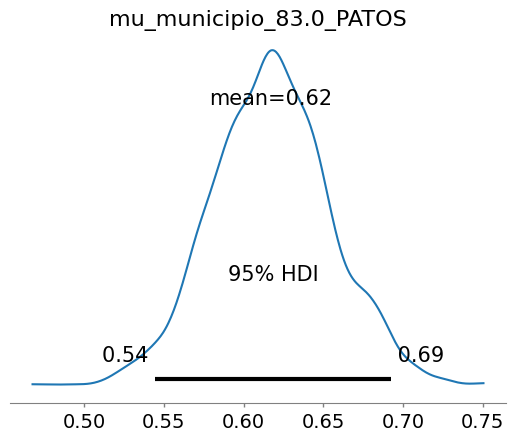

In [164]:
az.plot_posterior(trace, var_names=["mu_municipio_83.0_PATOS"],hdi_prob=0.95)

### ANALISE ANF 83 ###
------


In [166]:
import os

# Path to the directory containing Excel files
result_path = "_RESULTADO"

# List to store dataframes
dfs = []

# Iterate through all files in the directory
for file in os.listdir(result_path):
    if file.endswith(".xlsx"):
        file_path = os.path.join(result_path, file)
        dfs.append(pd.read_excel(file_path))

# Concatenate all dataframes
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the concatenated dataframe
concatenated_df.to_excel('consolidado_83.xlsx')